# Aidan's Work for Airline Reviews

## Data Processing

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("./Airlines Reviews and Rating.csv")

In [3]:
df.head(3)

,Aircraft Type,Users Reviews,Country,Type_of_Travellers,Route,Seat_Types,Seat Comfort,Date Flown,Cabin Staff Service,Ground Service,Food & Beverages,Wifi & Connectivity,Inflight Entertainment,Value For Money,Recommended
0,NaN,✅Trip Verified| Cancelled our flight last-min...,United Kingdom,Couple Leisure,London Heathrow to Tokyo,Economy Class,1.0,Sep-23,1.0,2.0,1.0,NaN,3.0,1,no
1,NaN,"✅Trip Verified| I had a flight from Miami, Flo...",United States,Solo Leisure,Miami to Dublin via London Heathrow,Business Class,1.0,Aug-23,3.0,1.0,2.0,1.0,1.0,1,no
2,NaN,✅Trip Verified| We started our day with BA in...,United States,Business,Prague to San Francisco via London,Business Class,1.0,Sep-23,3.0,1.0,3.0,1.0,NaN,1,no


In [4]:
df.Recommended.value_counts().idxmax()

'no'

### Baseline Accuracy

In [5]:
accuracy = df.Recommended.value_counts().no / (df.Recommended.value_counts().no + df.Recommended.value_counts().yes)
print('Baseline Accuracy:', accuracy.round(3))

Baseline Accuracy: 0.613


In [6]:
df.dtypes

Aircraft Type              object
Users Reviews              object
Country                    object
Type_of_Travellers         object
Route                      object
Seat_Types                 object
Seat Comfort              float64
Date Flown                 object
Cabin Staff Service       float64
Ground Service            float64
Food & Beverages          float64
Wifi & Connectivity       float64
Inflight Entertainment    float64
Value For Money             int64
Recommended                object
dtype: object

In [7]:
# Categorical Types
df['Aircraft Type'] = df['Aircraft Type'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Type_of_Travellers'] = df['Type_of_Travellers'].astype('category')
df['Seat_Types'] = df['Seat_Types'].astype('category')
df['Date Flown'] = df['Date Flown'].astype('category')
df['Recommended'] = df['Recommended'].astype('category')

# These floats could be ints
df['Seat Comfort'] = df['Seat Comfort'].astype(pd.Int64Dtype())
df['Cabin Staff Service'] = df['Cabin Staff Service'].astype(pd.Int64Dtype())
df['Ground Service'] = df['Ground Service'].astype(pd.Int64Dtype())
df['Wifi & Connectivity'] = df['Wifi & Connectivity'].astype(pd.Int64Dtype())
df['Food & Beverages'] = df['Food & Beverages'].astype(pd.Int64Dtype())
df['Inflight Entertainment'] = df['Inflight Entertainment'].astype(pd.Int64Dtype())

In [8]:
# The route could be broken into two categories
# First fix broken entries
df.loc[df[df.Route == 'London Singapore '].index[0], 'Route'] = 'London to Singapore'
df.loc[df[df.Route == 'doha to londonDoha to London'].index[0], 'Route'] = 'Doha to London'
df.loc[df[df.Route == 'Bucharest to London Heathrow to Los Angeles'].index[0], 'Route'] = 'Bucharest to London Heathrow Los Angeles'
df.loc[df[df.Route == 'Edinburgh-Florence '].index[0], 'Route'] = 'Edinburgh to Florence'
df.loc[df[df.Route == 'YVR-LIS via LHR'].index[0], 'Route'] = 'YVR to LHR to LIS'
df.loc[df[df.Route == 'MAN-LHR '].index[0], 'Route'] = 'MAN to LHR'
df.loc[df[df.Route == 'LHR-BOM'].index[0], 'Route'] = 'LHR to DEN'
df.loc[df[df.Route == 'ORD-LHR'].index[0], 'Route'] = 'ORD to LHR'
df.loc[df[df.Route == 'LHR-DEN'].index[0], 'Route'] = 'LHR to DEN'
df.loc[df[df.Route == 'LHR-GLA'].index[0], 'Route'] = 'LHR to GLA'
df.loc[df[df.Route == 'GLA-LHR'].index[0], 'Route'] = 'GLA to LHR'
df.loc[df[df.Route == 'FRA-LHR '].index[0], 'Route'] = 'FRA to LHR'
df.loc[df[df.Route == 'London-Vancouver return'].index[0], 'Route'] = 'London to Vancouver'
df.loc[df[df.Route == 'LHR-ORD'].index[0], 'Route'] = 'LHR to ORD'
df.loc[df[df.Route == 'BOM-LHR'].index[0], 'Route'] = 'BOM to LHR'
df.loc[df[df.Route == 'LHR-BOM'].index[0], 'Route'] = 'LHR to BOM'

In [9]:
df['Route'].apply(lambda x: x.split(' to ') if type(x) is str else x)
countries = df['Route'].apply(lambda x: x.split(' to ') if type(x) is str else x)
countries = countries.apply(lambda x: [x[0], x[1].split('via')[1], x[1].split('via')[0]] if (type(x) is list and x[1].find('via') != -1) else x)
max_countries = countries.apply(lambda x: len(x) if (type(x) is list) else 0).max()

In [10]:
for i in range(max_countries):
    df['country_' + str(i)] = countries.apply(lambda x: x[i] if (type(x) is list and (len(x)) > i) else np.nan)

df = df.drop('Route', axis=1)
df['country_0'] = df['country_0'].astype('category')
df['country_1'] = df['country_1'].astype('category')
df['country_2'] = df['country_2'].astype('category')
df['country_3'] = df['country_3'].astype('category')

In [11]:
df.dtypes

Aircraft Type             category
Users Reviews               object
Country                   category
Type_of_Travellers        category
Seat_Types                category
Seat Comfort                 Int64
Date Flown                category
Cabin Staff Service          Int64
Ground Service               Int64
Food & Beverages             Int64
Wifi & Connectivity          Int64
Inflight Entertainment       Int64
Value For Money              int64
Recommended               category
country_0                 category
country_1                 category
country_2                 category
country_3                 category
dtype: object

## KNN Classifier with just numbers (no hyperparameter tuning)

In [12]:
df_train, df_test = train_test_split(df, train_size=0.8, stratify=df.Recommended)

In [13]:
X_train = df_train.drop('Recommended', axis=1)
X_test = df_test.drop('Recommended', axis=1)

y_train = df_train.Recommended
y_test = df_test.Recommended

X_train = X_train.select_dtypes(include='number').apply(lambda x: x.fillna(-1))
X_test = X_test.select_dtypes(include='number').apply(lambda x: x.fillna(-1))

In [14]:
# Simple demonstration of training accuracy
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)
round(knn.score(X_test, y_test), 3)

0.924

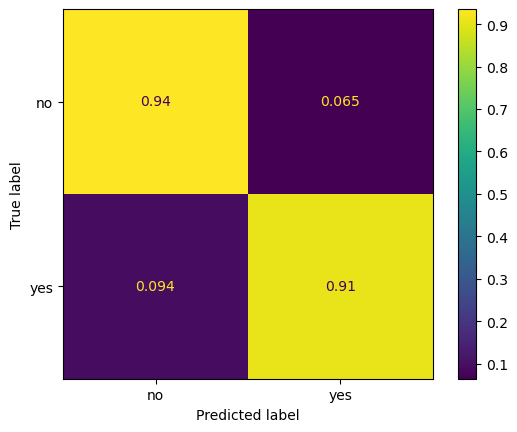

In [15]:
y_test_pred = knn.predict(X_test)

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize='true', labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

In [16]:
print(classification_report(y_true=y_test, y_pred=y_test_pred, labels=knn.classes_))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94       403
         yes       0.90      0.91      0.90       255

    accuracy                           0.92       658
   macro avg       0.92      0.92      0.92       658
weighted avg       0.92      0.92      0.92       658



## Word Processing with a Random Forest

In [17]:
X_reviews = df['Users Reviews']
X_reviews = X_reviews.apply(lambda x: list(set(x.lower().split())))


allWords = set()

pattern = re.compile('\W')

for review in X_reviews:
    for word in review:
        cleanWord = re.sub(pattern, '', word)
        allWords.add(cleanWord)

allWords.discard('')
print(len(allWords))

14709


In [18]:
wordSeries = dict()

for word in allWords:
    wordSeries.update({word:pd.Series(data=False, index=X_reviews.index, name=word)})

for i in X_reviews.index:
    review = X_reviews.iloc[i]
    for word in review:
        cleanWord = re.sub(pattern, '', word)
        if (cleanWord != ''):
            wordSeries[cleanWord][i] = True

X_words = pd.concat(wordSeries.values(), axis=1)

In [19]:
y = df.Recommended

df_words = pd.concat([X_words, y], axis=1)

df_words

,atone,comments,contributory,beard,sardinia,unimportant,4000,mayo,nurse,satellite,...,dissapointing,relax,ovens,stainless,recorded,walsh,off,showers,killing,Recommended
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,no
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,no
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,no
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,no
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,no
3286,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,yes
3287,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,no
3288,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,yes


In [20]:
df_words_train, df_words_test = train_test_split(df_words, train_size=0.8, stratify=df.Recommended)

In [21]:
X_words_train = df_words_train.drop('Recommended', axis=1)
X_words_test = df_words_test.drop('Recommended', axis=1)

y_words_train = df_words_train.Recommended
y_words_test = df_words_test.Recommended

In [22]:
forest = RandomForestClassifier()
grid = {}
rfCV = GridSearchCV(estimator=forest, param_grid=grid, n_jobs=-1,return_train_score=True)
rfCV.fit(X_words_train, y_words_train)
rfCV.best_estimator_.score(X_words_train, y_words_train)

1.0

In [23]:
print("Random Forest Accuracy:", rfCV.best_estimator_.score(X_words_test, y_words_test))

Random Forest Accuracy: 0.8434650455927052


<Axes: xlabel='Feature Name'>

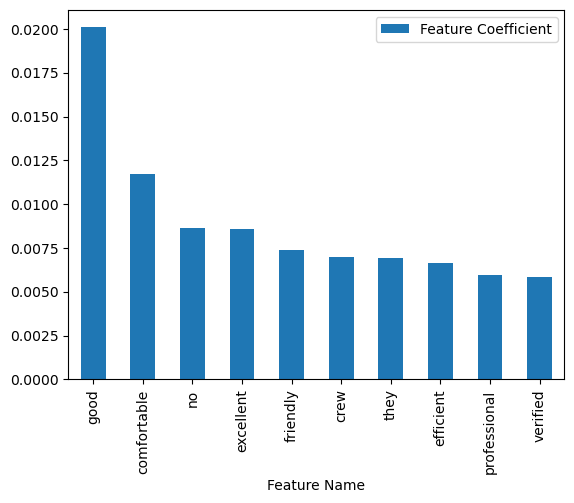

In [24]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = rfCV.best_estimator_.feature_importances_
feature_importances['Feature Name'] = rfCV.best_estimator_.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

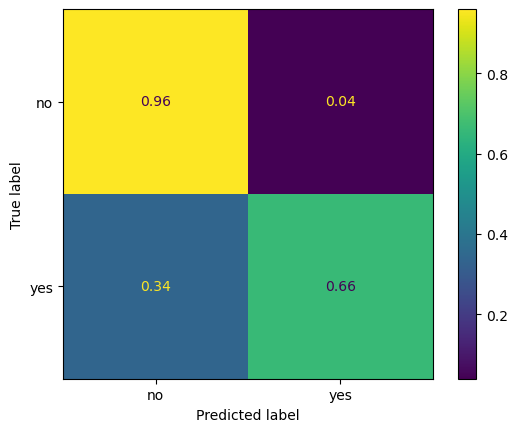

In [25]:
y_word_pred = rfCV.best_estimator_.predict(X_words_test)

cm = confusion_matrix(y_true=y_words_test, y_pred=y_word_pred, normalize='true', labels=rfCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfCV.best_estimator_.classes_)
disp.plot()

In [26]:
print(classification_report(y_true=y_words_test, y_pred=y_word_pred, labels=rfCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.82      0.96      0.88       403
         yes       0.91      0.66      0.77       255

    accuracy                           0.84       658
   macro avg       0.86      0.81      0.82       658
weighted avg       0.85      0.84      0.84       658



## Prediction based on all features (no hyperparameter tuning)

In [27]:
X_words = df_words.drop('Recommended', axis=1)
X_num = df.select_dtypes(include='number')
X_cat = df.select_dtypes(include='category').apply(lambda x: x.cat.add_categories("None")).drop('Recommended', axis=1)
X_cat = X_cat.fillna("None")
X_cat = pd.get_dummies(X_cat)

X_num = X_num.fillna(-1)

df_full = pd.concat([X_words, X_num, X_cat, df.Recommended], axis=1)

In [28]:
df_full_train, df_full_test = train_test_split(df_full, train_size=0.8, stratify=df.Recommended)

In [29]:
X_full_train = df_full_train.drop('Recommended', axis=1)
X_full_test = df_full_test.drop('Recommended', axis=1)

y_full_train = df_full_train.Recommended
y_full_test = df_full_test.Recommended

stnd = StandardScaler().set_output(transform='pandas')
X_train_num = X_full_train.select_dtypes(include='number')
X_test_num = X_full_test.select_dtypes(include='number')

X_train_num = stnd.fit_transform(X_train_num)
X_test_num = stnd.transform(X_test_num)

X_full_train = pd.concat([X_train_num, X_full_train.select_dtypes(exclude='number')], axis=1)
X_full_test = pd.concat([X_test_num, X_full_test.select_dtypes(exclude='number')], axis=1)

### Random Forest

In [30]:
forest = RandomForestClassifier()
grid = {}
rfCV = GridSearchCV(estimator=forest, param_grid=grid, n_jobs=-1,return_train_score=True, cv=2)
rfCV.fit(X_full_train, y_full_train)
print(round(rfCV.cv_results_['mean_test_score'].max(), 3))
print(rfCV.best_params_)

0.921
{}


In [31]:
print("Random Forest Accuracy:", round(rfCV.best_estimator_.score(X_full_test, y_full_test), 3))

Random Forest Accuracy: 0.924


<Axes: xlabel='Feature Name'>

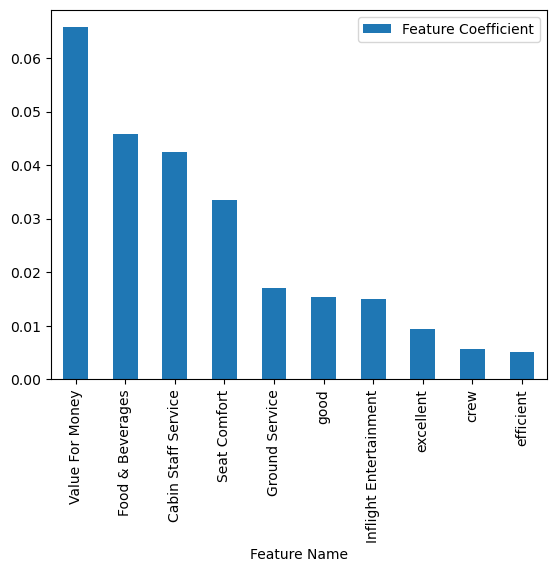

In [32]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = rfCV.best_estimator_.feature_importances_
feature_importances['Feature Name'] = rfCV.best_estimator_.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

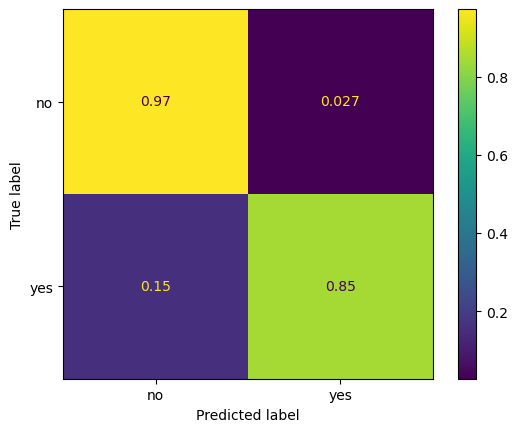

In [33]:
y_full_test_pred = rfCV.best_estimator_.predict(X_full_test)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=rfCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfCV.best_estimator_.classes_)
disp.plot()

In [34]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=rfCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.91      0.97      0.94       403
         yes       0.95      0.85      0.90       255

    accuracy                           0.92       658
   macro avg       0.93      0.91      0.92       658
weighted avg       0.93      0.92      0.92       658



### Gradient Boosting Classifier

In [35]:
gradient = GradientBoostingClassifier()
grid = {}
gbCV = GridSearchCV(estimator=gradient, param_grid=grid, n_jobs=-1,return_train_score=True)
gbCV.fit(X_full_train, y_full_train)
gbCV.best_estimator_.score(X_full_train, y_full_train)

0.9502279635258358

In [36]:
print("Gradient Boosting Accuracy:", round(gbCV.best_estimator_.score(X_full_test, y_full_test), 3))
print(gbCV.best_params_)

Gradient Boosting Accuracy: 0.929
{}


<Axes: xlabel='Feature Name'>

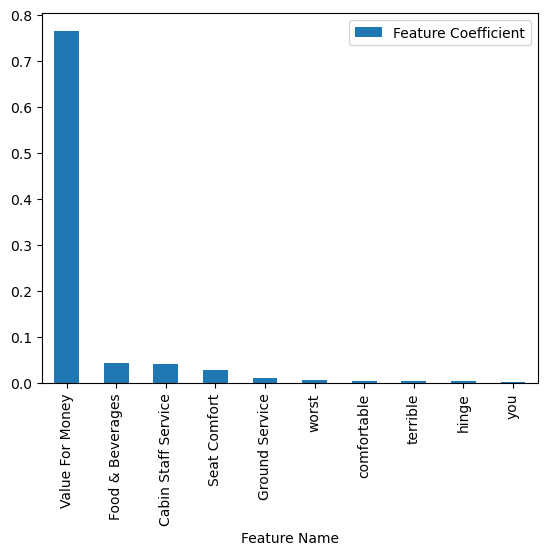

In [37]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = gbCV.best_estimator_.feature_importances_
feature_importances['Feature Name'] = gbCV.best_estimator_.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

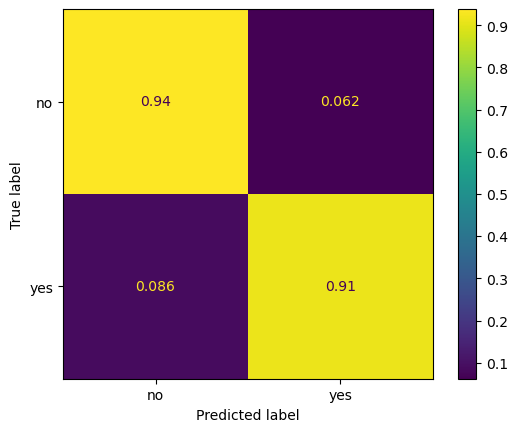

In [38]:
y_full_test_pred = gbCV.best_estimator_.predict(X_full_test)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=gbCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbCV.best_estimator_.classes_)
disp.plot()

In [39]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=gbCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94       403
         yes       0.90      0.91      0.91       255

    accuracy                           0.93       658
   macro avg       0.92      0.93      0.92       658
weighted avg       0.93      0.93      0.93       658



### Logistic Regression

In [40]:
lr = LogisticRegression()
grid = {}
lrCV = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1,return_train_score=True)
lrCV.fit(X_full_train, y_full_train)
lrCV.best_estimator_.score(X_full_train, y_full_train)

1.0

In [41]:
print("Logistic Regression Accuracy:", round(lrCV.best_estimator_.score(X_full_test, y_full_test), 3))
print(lrCV.best_params_)

Logistic Regression Accuracy: 0.936
{}


<Axes: xlabel='Feature Name'>

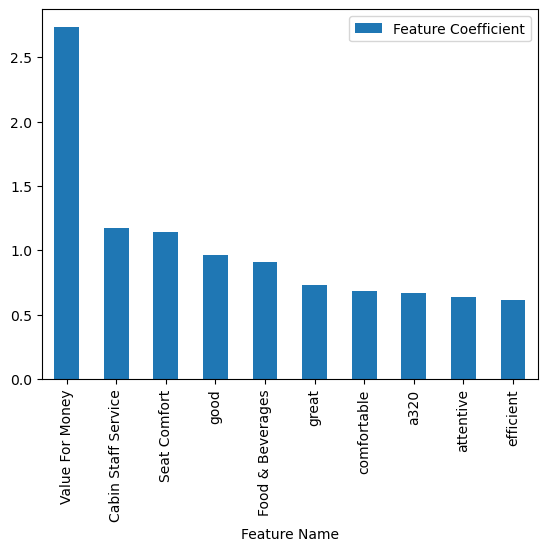

In [42]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = lrCV.best_estimator_.coef_[0]
feature_importances['Feature Name'] = lrCV.best_estimator_.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

<Axes: xlabel='Feature Name'>

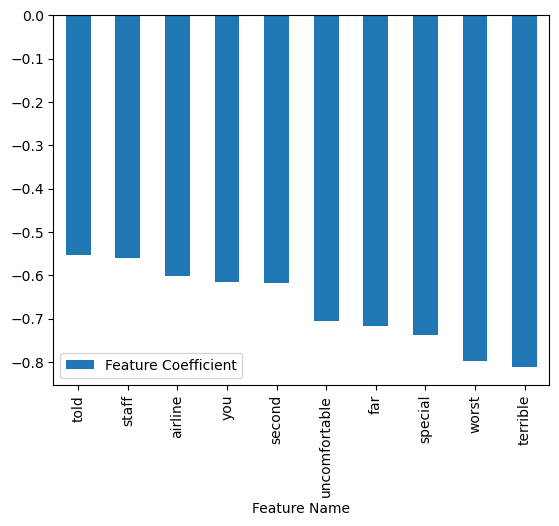

In [43]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = lrCV.best_estimator_.coef_[0]
feature_importances['Feature Name'] = lrCV.best_estimator_.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).tail(10).plot.bar(x='Feature Name', y='Feature Coefficient')

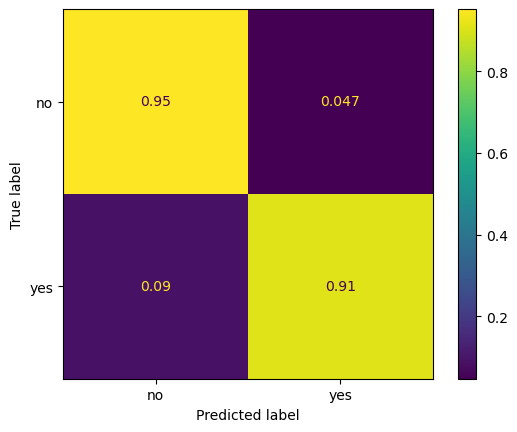

In [44]:
y_full_test_pred = lrCV.best_estimator_.predict(X_full_test)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=lrCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lrCV.best_estimator_.classes_)
disp.plot()

In [45]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=lrCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.94      0.95      0.95       403
         yes       0.92      0.91      0.92       255

    accuracy                           0.94       658
   macro avg       0.93      0.93      0.93       658
weighted avg       0.94      0.94      0.94       658



## Use L1 logistic regression to select the most useful features

In [46]:
lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, verbose=1)
# grid = {}
# lrCV = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1,return_train_score=True)
lr.fit(X_full_train, y_full_train)
lr.score(X_full_train, y_full_train)

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  #CD cycles 3
iter   7  #CD cycles 1
iter   8  #CD cycles 4
iter   9  #CD cycles 1
iter  10  #CD cycles 8
iter  11  #CD cycles 1
iter  12  #CD cycles 25
iter  13  #CD cycles 3
optimization finished, #iter = 13
Objective value = 270.284112
#nonzeros/#features = 365/16140


0.9943009118541033

In [47]:
print("L1 Logistic Regression Accuracy:", round(lr.score(X_full_test, y_full_test), 3))

L1 Logistic Regression Accuracy: 0.921


<Axes: xlabel='Feature Name'>

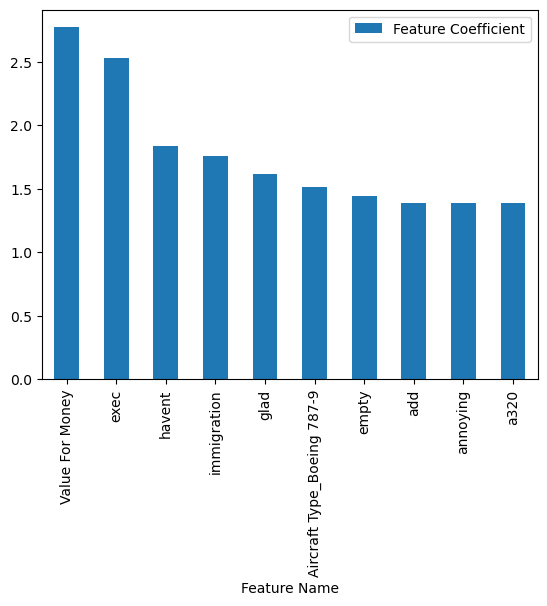

In [48]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = lr.coef_[0]
feature_importances['Feature Name'] = lr.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

<Axes: xlabel='Feature Name'>

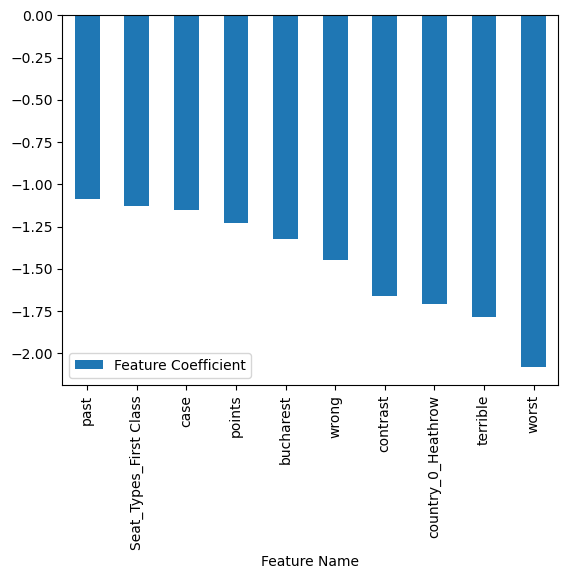

In [49]:
feature_importances.sort_values('Feature Coefficient', ascending=False).tail(10).plot.bar(x='Feature Name', y='Feature Coefficient')

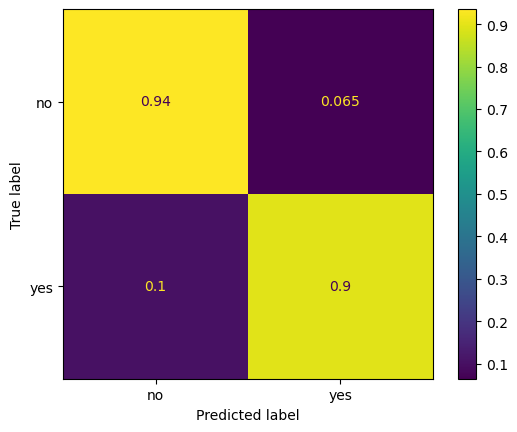

In [50]:
y_full_test_pred = lr.predict(X_full_test)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lrCV.best_estimator_.classes_)
disp.plot()

In [51]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=lr.classes_))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94       403
         yes       0.90      0.90      0.90       255

    accuracy                           0.92       658
   macro avg       0.92      0.92      0.92       658
weighted avg       0.92      0.92      0.92       658



In [52]:
significant_features = feature_importances[feature_importances['Feature Coefficient'] != 0]['Feature Name']

In [53]:
X_train_significant = X_full_train[significant_features]
X_test_signficant = X_full_test[significant_features]

### Random Forest (tuned hyperparameters and feature reduction)

In [54]:
forest = RandomForestClassifier(n_estimators=525)
forest.fit(X_train_significant, y_full_train)

RandomForestClassifier(n_estimators=525)

In [55]:
print("Random Forest Accuracy:", round(forest.score(X_test_signficant, y_full_test), 3))

Random Forest Accuracy: 0.932


<Axes: xlabel='Feature Name'>

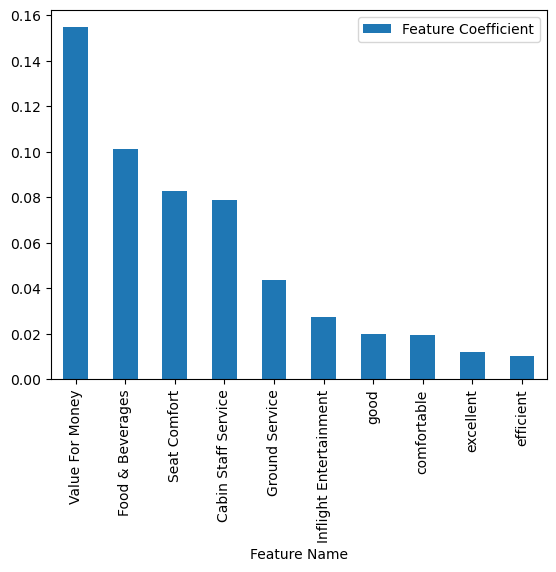

In [56]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = forest.feature_importances_
feature_importances['Feature Name'] = forest.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

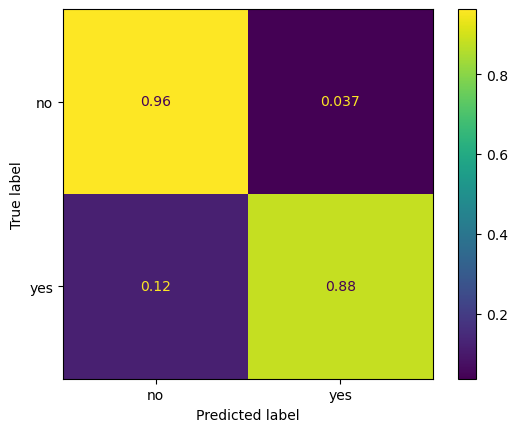

In [57]:
y_full_test_pred = forest.predict(X_test_signficant)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()

In [58]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=forest.classes_))

              precision    recall  f1-score   support

          no       0.93      0.96      0.95       403
         yes       0.94      0.88      0.91       255

    accuracy                           0.93       658
   macro avg       0.93      0.92      0.93       658
weighted avg       0.93      0.93      0.93       658



### Gradient Boosting Classifier (Tuned and feature reduced)

In [59]:
gradient = GradientBoostingClassifier(loss='log_loss', learning_rate=0.78, n_estimators=935)
grid = {}
gbCV = GridSearchCV(estimator=gradient, param_grid=grid, n_jobs=-1,return_train_score=True)
gbCV.fit(X_train_significant, y_full_train)

GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.78,
                                                  n_estimators=935),
             n_jobs=-1, param_grid={}, return_train_score=True)

In [60]:
print("Best Score:", gbCV.best_score_.round(3))
print("Best params:", gbCV.best_params_)

Best Score: 0.945
Best params: {}


<Axes: xlabel='Feature Name'>

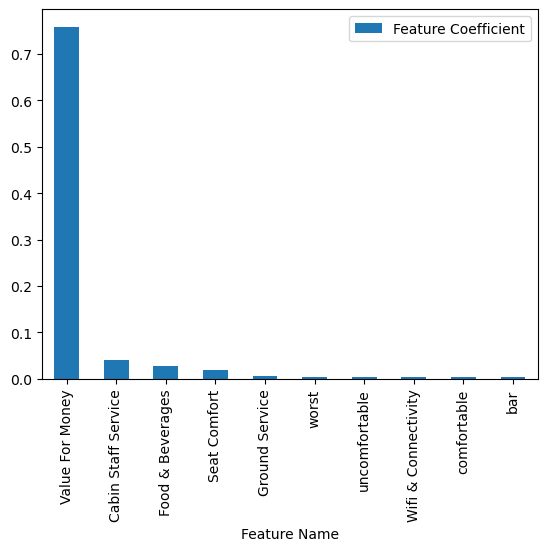

In [61]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = gbCV.best_estimator_.feature_importances_
feature_importances['Feature Name'] = gbCV.best_estimator_.feature_names_in_
feature_importances.sort_values('Feature Coefficient', ascending=False).head(10).plot.bar(x='Feature Name', y='Feature Coefficient')

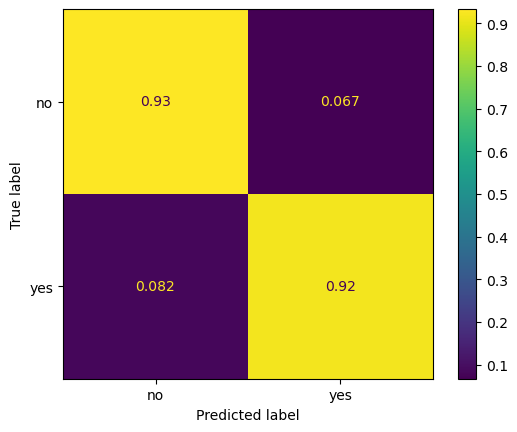

In [62]:
y_full_test_pred = gbCV.best_estimator_.predict(X_test_signficant)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=gbCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbCV.best_estimator_.classes_)
disp.plot()

In [63]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=gbCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.95      0.93      0.94       403
         yes       0.90      0.92      0.91       255

    accuracy                           0.93       658
   macro avg       0.92      0.93      0.92       658
weighted avg       0.93      0.93      0.93       658



### Logistic Regression (With tuning and feature selection)

In [64]:
lr = LogisticRegression()
grid = {}
lrCV = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1,return_train_score=True)
lrCV.fit(X_train_significant, y_full_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1, param_grid={},
             return_train_score=True)

In [65]:
print("Best Score:", lrCV.best_score_.round(3))
print("Best params:", lrCV.best_params_)

Best Score: 0.959
Best params: {}


<Axes: xlabel='Feature Name'>

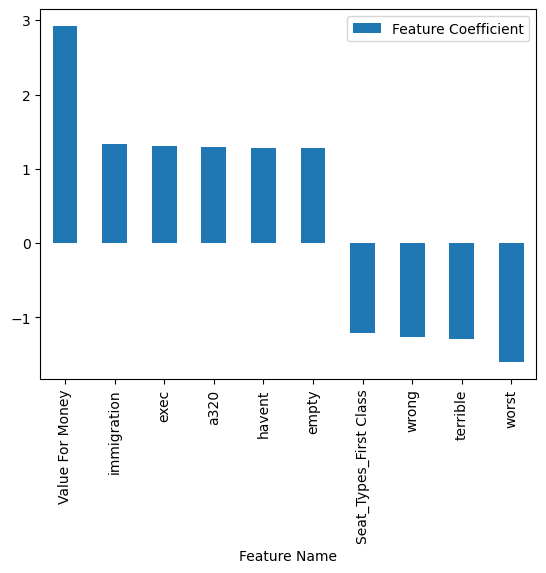

In [66]:
feature_importances = pd.DataFrame()
feature_importances['Feature Coefficient'] = lrCV.best_estimator_.coef_[0]
feature_importances['Feature Name'] = lrCV.best_estimator_.feature_names_in_
feature_importances['Absolute Coefficient'] = feature_importances['Feature Coefficient'].abs()
feature_importances.sort_values('Absolute Coefficient', ascending=False).head(10).sort_values('Feature Coefficient', ascending=False).plot.bar(x='Feature Name', y='Feature Coefficient')

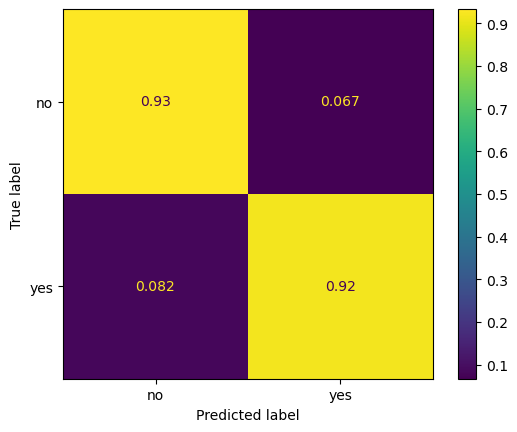

In [67]:
y_full_test_pred = gbCV.best_estimator_.predict(X_test_signficant)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=gbCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbCV.best_estimator_.classes_)
disp.plot()

In [68]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=gbCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.95      0.93      0.94       403
         yes       0.90      0.92      0.91       255

    accuracy                           0.93       658
   macro avg       0.92      0.93      0.92       658
weighted avg       0.93      0.93      0.93       658



In [81]:
df.iloc[df_full_test[y_full_test != y_full_test_pred].index].head(3)

,Aircraft Type,Users Reviews,Country,Type_of_Travellers,Seat_Types,Seat Comfort,Date Flown,Cabin Staff Service,Ground Service,Food & Beverages,Wifi & Connectivity,Inflight Entertainment,Value For Money,Recommended,country_0,country_1,country_2,country_3
1404,A320,✅Verified Review| Flew Leeds Bradford to Gen...,New Zealand,Solo Leisure,Economy Class,4,Oct-17,4,4,2,<NA>,<NA>,2,yes,Leeds Bradford,London Heathrow,Geneva,NaN
2625,Boeing 777-300,We paid for World Traveller Plus (Premium Econ...,United States,Couple Leisure,Premium Economy,3,Sep-15,4,3,4,3,3,2,no,DFW,LHR,NaN,NaN
882,NaN,✅Trip Verified| London to Seville. Following ...,United Kingdom,Couple Leisure,Economy Class,<NA>,Mar-19,<NA>,4,<NA>,<NA>,<NA>,4,yes,London,Seville,NaN,NaN


### Using PCA to reduce dimensionality (for KNN and SVM)

In [70]:
pca = PCA()
pca.fit(X_train_significant)

PCA()

In [71]:
pca_ratios = pd.DataFrame()
pca_ratios['Explained Variance'] = pca.explained_variance_ratio_

reduced = pca_ratios[pca_ratios['Explained Variance'] > pca_ratios.mean().iloc[0]]
num_columns = len(reduced)
print("Explained variability:",reduced.sum().iloc[0])
print("Number of Columns:",num_columns)

Explained variability: 0.7243684040006961
Number of Columns: 101


In [72]:
pca = PCA(n_components=num_columns)
X_train_reduced = pca.fit_transform(X_train_significant)
X_test_reduced = pca.transform(X_test_signficant)

### KNN (Tuned and features strongly reduced)

In [73]:
knn = KNeighborsClassifier(n_jobs=-1)
grid = {'n_neighbors':[14],'weights':['distance'],'p':[2]}
knnCV = GridSearchCV(estimator=knn, param_grid=grid, n_jobs=-1,return_train_score=True)
knnCV.fit(X_train_reduced, y_full_train)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [14], 'p': [2],
                         'weights': ['distance']},
             return_train_score=True)

In [74]:
print("Best Score:", knnCV.best_score_.round(3))
print("Best params:", knnCV.best_params_)

Best Score: 0.927
Best params: {'n_neighbors': 14, 'p': 2, 'weights': 'distance'}


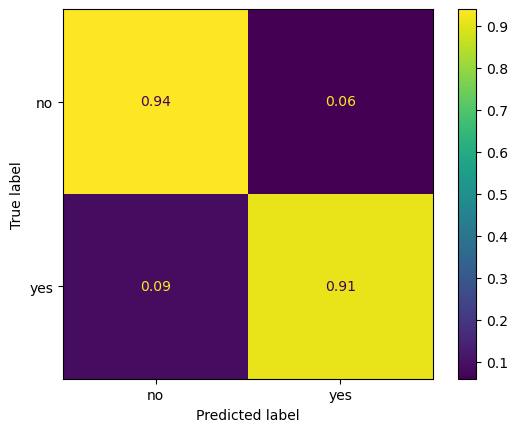

In [75]:
y_full_test_pred = knnCV.best_estimator_.predict(X_test_reduced)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=knnCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knnCV.best_estimator_.classes_)
disp.plot()

In [76]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=knnCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.94      0.94      0.94       403
         yes       0.91      0.91      0.91       255

    accuracy                           0.93       658
   macro avg       0.92      0.93      0.92       658
weighted avg       0.93      0.93      0.93       658



### SVM (Tuned and features strongly reduced)

In [77]:
# As mentioned in class, an SVC just uses multiple SVMs to predict multiple classes.
svc = SVC(C=2)
grid = {}
svcCV = GridSearchCV(estimator=svc, param_grid=grid, n_jobs=-1,return_train_score=True)
svcCV.fit(X_train_reduced, y_full_train)

GridSearchCV(estimator=SVC(C=2), n_jobs=-1, param_grid={},
             return_train_score=True)

In [78]:
print("Best Score:", svcCV.best_score_.round(3))
print("Best params:", svcCV.best_params_)

Best Score: 0.935
Best params: {}


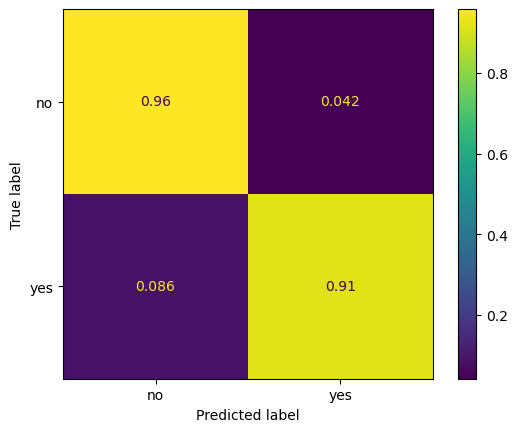

In [79]:
y_full_test_pred = svcCV.best_estimator_.predict(X_test_reduced)

cm = confusion_matrix(y_true=y_full_test, y_pred=y_full_test_pred, normalize='true', labels=svcCV.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svcCV.best_estimator_.classes_)
disp.plot()

In [80]:
print(classification_report(y_true=y_full_test, y_pred=y_full_test_pred, labels=svcCV.best_estimator_.classes_))

              precision    recall  f1-score   support

          no       0.95      0.96      0.95       403
         yes       0.93      0.91      0.92       255

    accuracy                           0.94       658
   macro avg       0.94      0.94      0.94       658
weighted avg       0.94      0.94      0.94       658

